In [851]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
from scipy.stats import norm
import sqlite3
from datetime import timedelta
import matplotlib.lines as mlines
import multiprocessing

class BSHelper:
    # Calculates rolling volatility based on the 'close' price
    def rolling_volatility(self, data: pd.DataFrame, window: int = 30) -> pd.Series:
        """
        Calculate rolling volatility over a specified window.
        """
        return data['close'].rolling(window=window).std()
    
    def black_scholes(self, St, K, r, T, t, sigma):
        time = (T-t)/252
        d1 = (np.log(St / K) + (r + 0.5 * sigma**2) * time) / (sigma * np.sqrt(time))
        d2 = d1 - sigma * np.sqrt(time)

        calculated_call_price = St * norm.cdf(d1) - K * np.exp(-r * time) * norm.cdf(d2)
        
        return calculated_call_price

    def dc_dsigma(self, St, K, r, T, t, sigma):
        time = (T-t)/252
        dphi_dsigma = np.sqrt(time)/2 - ((np.log(St/K) + r*T)/(sigma**2 * np.sqrt(time)))
        dc_dsigma_val = (St + K*np.exp(-r*T))*dphi_dsigma - K*np.exp(-r*T)*np.sqrt(T)
        return dc_dsigma_val
    
    def newton_rhapson(self, St, K, r, T, t, sigma_est, call_price, tolerance=0.001, suppressLogs=False, max_iterations: int = 1000) -> float:
        sigma = sigma_est


        for i in range(0, max_iterations):
            fx = call_price - self.black_scholes(St, K, r, T, t, sigma)
            dfx = self.dc_dsigma(St, K, r, T, t, sigma)
            
            if abs(dfx) < 1e-12:
                print("Derivative is close to zero, Newton-Raphson may fail.")

            sigma_next = sigma - fx/dfx
            
            if abs(fx) <= tolerance:
                print(f"sigma={sigma}, sigma_next={sigma_next}, i={i}")
                sigma = sigma_next
                
                if not suppressLogs:
                    print(f'found the value at the {i}th iteration')
                
                break
            
            if i == max_iterations-1:
                print(f'cound not find root after {max_iterations} iterations')
            
            sigma = sigma_next

        if not suppressLogs:
            print(f'Implied Volatility: {sigma}, Call Price: {self.black_scholes(St, K, r, T, t, sigma)}')
        
        return sigma
    
    def get_realized_vol(self, dataset, time=21, fill_initial=True):
        dataset['returns'] = np.log(dataset["close"]/dataset["close"].shift(1))
        dataset.fillna(0, inplace=True)
        volatility = dataset.returns.rolling(window=time).std(ddof=0)*np.sqrt(252)
        if fill_initial:
            # Fill the first (time-1) NaN values with the first non-NaN volatility value
            first_valid = volatility[time-1]
            volatility.iloc[:time-1] = first_valid
        return volatility
    
    def get_historical_vol(self, dataset, type, time=21):
        if type == 'parkinson':
            hl_log_sq = (np.log(dataset['high']/dataset['low'])) **2
            factor = 1/(4 * np.log(2))
            
            parkinson_daily_var = hl_log_sq * factor
            rolling_var = parkinson_daily_var.rolling(window=time).mean()
            
            # Annualize
            parkinson_vol = np.sqrt(rolling_var * 252)
            return parkinson_vol
        elif type == 'gk':
            log_hl_sq = (np.log(dataset['high']/dataset['low']))**2
            log_co_sq = (np.log(dataset['close']/dataset['open']))**2
            
            daily_variance = 0.5 * log_hl_sq - (2 * np.log(2) - 1) * log_co_sq
            
            rolling_var = daily_variance.rolling(window = time).mean()
            
            # Annualize
            gk_vol = np.sqrt(rolling_var * 252)
            
            return gk_vol
    
    # Sets NaN values to 0 and categorizes volatility into states
    def qcut_volatility(self, volatility: pd.Series, nStates: int = 3):

        volatility.fillna(0, inplace=True)
        volatility_states = pd.qcut(volatility, q=nStates, labels=range(nStates))
        df_vol_states = pd.DataFrame({
            'volatility': volatility,
            'volatility_state': volatility_states
        })
        df_vol_states['mean_volatility'] = df_vol_states.groupby('volatility_state', observed=False)['volatility'].transform('mean')
        return df_vol_states
    
    # Function to get the holding times and transitions
    def getHoldingTimesAndTransitions(self, df_vol_states: pd.DataFrame):
            
        nStates = df_vol_states['volatility_state'].cat.categories.size
        transitions = np.zeros((nStates, nStates))
        holding_times = np.zeros(nStates)

        for i in range(1, len(df_vol_states['volatility_state'])):
            s_prev = df_vol_states['volatility_state'].iloc[i-1]
            s_curr = df_vol_states['volatility_state'].iloc[i]
            # delta_t = (df.iloc[i]['Date'] - df.iloc[i-1]['Date']).days # 1 day is the delta

            holding_times[s_prev] += 1
            if s_prev != s_curr:
                transitions[s_prev, s_curr] += 1
        
        return (holding_times, transitions)

    # Compute the Q Matrix
    def computeQMatrix(self, holding_times, transitions, df_vol_states: pd.DataFrame):
        nStates = nStates = df_vol_states['volatility_state'].cat.categories.size
        Q = np.zeros((nStates, nStates))

        for i in range(nStates):
            for j in range(nStates):
                if i != j:
                    Q[i, j] = transitions[i, j] / holding_times[i]
            Q[i, i] = -np.sum(Q[i, :])
        
        return Q
    
    def simulate_ctmc(self, Q, vol_state_df: pd.DataFrame, start_state: int, time_horizon: int):
        states = vol_state_df['volatility_state'].cat.categories.tolist()
        current_state = states.index(start_state)
        time = 0
        history = [(time, states[current_state])]

        while time < time_horizon:
            rate = -Q[current_state, current_state]
            time += np.random.exponential(1/rate)

            probs = (Q[current_state]/rate)
            probs[current_state] = 0 # No self-transition

            next_state = np.random.choice(range(len(states)), p=probs)

            current_state = next_state
            history.append((float(np.round(time,2)), states[current_state]))
        
        return history
    
    def _ctmc_worker(self, args):
        q_matrix, vol_state_df, start_state, time_horizon, num = args
        results = []
        for _ in range(num):
            results.append(self.simulate_ctmc(q_matrix, vol_state_df, start_state, time_horizon))
        return results
    
    def simulate_ctmc_parallel(self, q_matrix, vol_state_df: pd.DataFrame, start_state: int, time_horizon: int,
                           num_simulations: int = 1_000_000, num_cores: int = 1):
        chunk_size = num_simulations // num_cores
        args_list = [(q_matrix, vol_state_df, start_state, time_horizon, chunk_size) for _ in range(num_cores)]

        with multiprocessing.get_context("fork").Pool(num_cores) as pool:
            results = pool.map(self._ctmc_worker, args_list)
        return [item for sublist in results for item in sublist]
    
    # Return the unique states and corresponding volatility values
    def get_unique_states(self, vol_state_df: pd.DataFrame) -> pd.DataFrame:
        unique_states = vol_state_df[['volatility_state', 'mean_volatility']].groupby(['volatility_state'], observed=False).min()
        return unique_states
    
    # Return an array of one period volatility values for the generated ctmc
    def get_ctmc_sigmas(self, generated_ctmc: list, unique_states: pd.DataFrame) -> pd.DataFrame:
        one_period_states = []
        for j in range(len(generated_ctmc)):
            for i in range(len(generated_ctmc[j])):
                if generated_ctmc[j][i][0] >= 1.0:
                    one_period_states.append(int(generated_ctmc[j][i-1][1]))
                    break

        unique_states_dict = unique_states.to_dict()['mean_volatility']
        # Convert the dict to an array where index matches the state
        state_keys = sorted(unique_states_dict.keys())
        state_values = np.array([unique_states_dict[k] for k in state_keys])

        # Convert one_period_states to a numpy array for fast indexing
        one_period_states_arr = np.array(one_period_states)
        ctmc_sigmas = state_values[one_period_states_arr]
        return ctmc_sigmas
        

bsHelper = BSHelper()


In [852]:
vix_data = pd.read_csv('vix.csv')
vix_data = vix_data.rename(columns={"Date": "date"})
vix_data['date'] = pd.to_datetime(vix_data['date'])
vix_data.set_index('date', inplace=True)
vix_data = vix_data.loc['2022-04-18':] # Training start date
vix_data.head(4)

,vixo,vixh,vixl,vix,vxno,vxnh,vxnl,vxn
date,,,,,,,,
2022-04-18,24.52,24.60,21.98,22.17,30.47,30.91,29.16,29.53
2022-04-19,22.55,22.92,20.36,21.37,29.53,30.50,27.82,29.10
2022-04-20,21.13,21.32,19.75,20.32,29.12,29.82,28.03,28.47
2022-04-21,20.24,23.28,19.81,22.68,28.52,31.92,27.57,31.37


/var/folders/9g/6smd7t3d5z5_cv63r3b4w2cr0000gn/T/ipykernel_46972/3834682753.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  first_valid = volatility[time-1]
/var/folders/9g/6smd7t3d5z5_cv63r3b4w2cr0000gn/T/ipykernel_46972/3490872858.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


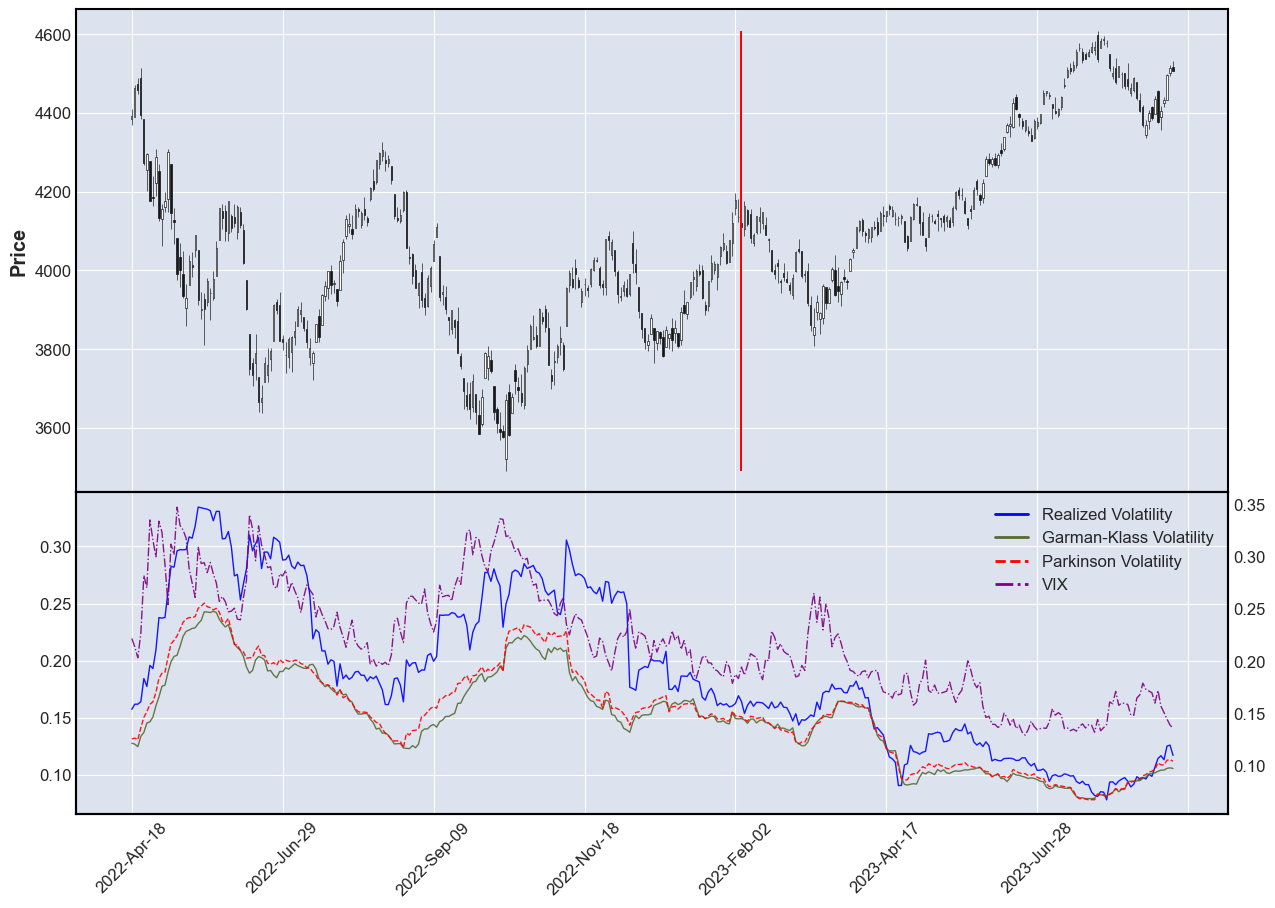

In [853]:
index_price_data = pd.read_csv('spx_ndx_rut.csv')

spx_price = index_price_data[index_price_data['ticker'] == 'SPX'].copy()
spx_price['date'] = pd.to_datetime(spx_price['date'])
spx_price.set_index('date', inplace=True)
spx_price['realized_21period_vol'] = bsHelper.get_realized_vol(spx_price, 21)
spx_price['parkinson_21period_vol'] = bsHelper.get_historical_vol(spx_price, 'parkinson', 21)
spx_price['gk_21period_vol'] = bsHelper.get_historical_vol(spx_price, 'gk', 21)
spx_price = spx_price.loc['2022-04-18':] # Training start date
spx_price = pd.concat([spx_price, (vix_data['vix']/100)], axis=1, join="inner") # Add VIX data

training_cutoff_date = '2023-02-06'

apds = [
    mpf.make_addplot(spx_price['realized_21period_vol'], panel=1, color='blue', linestyle='-', width=1, alpha=0.9),
    mpf.make_addplot(spx_price['gk_21period_vol'], panel=1, color='darkolivegreen', linestyle='-', width=1, alpha=0.9),
    mpf.make_addplot(spx_price['parkinson_21period_vol'], panel=1, color='red', linestyle='--', width=1, alpha=0.9),
    mpf.make_addplot(spx_price['vix'], panel=1, color='purple', linestyle='-.', width=1, alpha=0.9)
]

fig, axlist = mpf.plot(
    spx_price,
    addplot=apds,
    figscale=2,
    type='candle',
    vlines=dict(vlines=[training_cutoff_date], linewidths=0.2, colors='red'),
    returnfig=True,
    panel_ratios=(3, 2)
)

ax_volatility = axlist[2]
legend_lines = [
    mlines.Line2D([], [], color='blue', linestyle='-', label='Realized Volatility'),
    mlines.Line2D([], [], color='darkolivegreen', linestyle='-', label='Garman-Klass Volatility'),
    mlines.Line2D([], [], color='red', linestyle='--', label='Parkinson Volatility'),
    mlines.Line2D([], [], color='purple', linestyle='-.', label='VIX'),
]

ax_volatility.legend(handles=legend_lines, loc='upper right')
fig.tight_layout()

mpf.show()

### Loading Interest Rates

Start date: 2023-02-06, End date: 2023-08-31 00:00:00


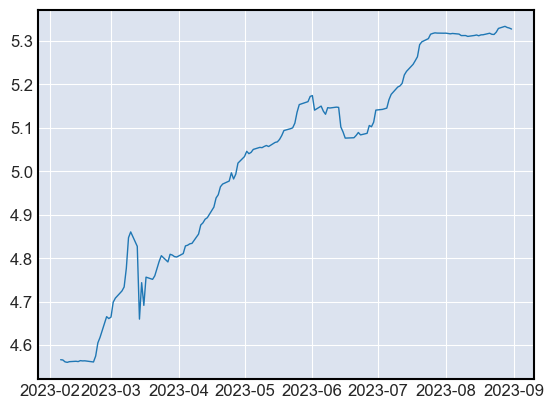

In [854]:
sofr = pd.read_csv('TSFR1and3M.csv')
sofr['Date'] = pd.to_datetime(sofr['Date'], dayfirst=True)
sofr.set_index('Date', inplace=True)
# start_date = spx_price.index.min()
start_date = training_cutoff_date
end_date = spx_price.index.max()
sofr = sofr[(sofr.index >= start_date) & (sofr.index <= end_date)]
print(f"Start date: {start_date}, End date: {end_date}")
plt.plot(sofr.index, sofr.TSFR1M, linewidth=1)

In [855]:

spx_train = spx_price.loc[:training_cutoff_date]
spx_test  = spx_price.loc[training_cutoff_date:]

volatility = spx_train['realized_21period_vol'].copy()
volatility.name = 'volatility'
vol_state_test_df = bsHelper.qcut_volatility(volatility, nStates=3)

holding_times, transitions = bsHelper.getHoldingTimesAndTransitions(vol_state_test_df)
q_matrix = bsHelper.computeQMatrix(holding_times, transitions, vol_state_test_df)
print(q_matrix)


[[-0.08955224  0.08955224  0.        ]
 [ 0.08955224 -0.17910448  0.08955224]
 [ 0.          0.08823529 -0.08823529]]


In [856]:
nTrials = 1_000_000
generated_ctmc = bsHelper.simulate_ctmc_parallel(q_matrix, vol_state_test_df, 0, 1, nTrials, num_cores=5)

In [857]:
unique_states = bsHelper.get_unique_states(vol_state_test_df)
unique_states

,mean_volatility
volatility_state,
0,0.178446
1,0.235166
2,0.293272


### Simulating the stock price using monte carlo

In [858]:
curdate = spx_test.iloc[1:2].index[0]
curdate_str = curdate.strftime('%Y-%m-%d')
expiry_date = '2023-02-17'
St = spx_price.loc[curdate_str].close
print(curdate_str)

2023-02-07


In [841]:
query = """
    SELECT date, symbol, 
    best_bid, best_offer, ROUND((best_bid + best_offer)/2,2) AS mid_price, 
    (strike_price/1000) AS strike_price, cp_flag, exdate, ticker exercise_style 
    FROM ialun 
    WHERE ticker = 'SPX'
    AND date = '""" + curdate_str + """'
    AND exdate = '""" + expiry_date + """'
    AND cp_flag = 'C'
    AND strike_price BETWEEN """ + str((St - 100)*1000) + ' AND ' + str((St + 100)*1000) + """
    AND symbol NOT LIKE 'SPXW%';
    """
conn = sqlite3.connect('ialun_db.sqlite')
spx_options_data = pd.read_sql(query, conn)
conn.close()

spx_options_data

,date,symbol,best_bid,best_offer,mid_price,strike_price,cp_flag,exdate,exercise_style
0,2023-02-07,SPX 230217C4065000,120.4,122.6,121.50,4065,C,2023-02-17,SPX
1,2023-02-07,SPX 230217C4070000,116.4,118.2,117.30,4070,C,2023-02-17,SPX
2,2023-02-07,SPX 230217C4075000,112.6,114.1,113.35,4075,C,2023-02-17,SPX
3,2023-02-07,SPX 230217C4080000,108.4,110.5,109.45,4080,C,2023-02-17,SPX
4,2023-02-07,SPX 230217C4085000,105.0,105.9,105.45,4085,C,2023-02-17,SPX
5,2023-02-07,SPX 230217C4090000,101.2,102.1,101.65,4090,C,2023-02-17,SPX
6,2023-02-07,SPX 230217C4095000,97.4,98.3,97.85,4095,C,2023-02-17,SPX
7,2023-02-07,SPX 230217C4100000,93.7,94.6,94.15,4100,C,2023-02-17,SPX
8,2023-02-07,SPX 230217C4105000,90.1,90.9,90.50,4105,C,2023-02-17,SPX
9,2023-02-07,SPX 230217C4110000,86.5,87.3,86.90,4110,C,2023-02-17,SPX


In [859]:
K = spx_options_data.iloc[0].strike_price
r = sofr.loc[curdate_str].TSFR1M/100 # Converting to percentage
T = (pd.to_datetime(expiry_date) - curdate).days # time to expiry
t = 0

# prev_date = vol_state_df.index[vol_state_df.index.get_loc(curdate_str) - 1]
# print(f'prev_date = {prev_date}')
# vol_state_df.loc[prev_date].volatility_state

# Use advanced indexing for fast lookup
ctmc_sigmas = bsHelper.get_ctmc_sigmas(generated_ctmc, unique_states)
s2 = ctmc_sigmas

## Stock Price SDE with geometric brownian motion (GBM)
$dS_t = r S_t dt + \sigma_{\eta_t} S_t\ dW_t^\mathbb{Q}\ ,\ \ \ \text{where } \sigma_{\eta_t} \in \{\sigma_1, \sigma_2\}$

$\text{for } 0 \leq t \leq s_1,\ \ \sigma_{\eta_t} = \sigma_1$

$S_t = S_0 \exp\left\{ \left( r - \dfrac{\sigma_1^2}{2} \right) t \ + \sigma_1\sqrt{t}\ Z_1\right\},\ \ \text{where  } Z_1 \sim \mathcal{N}(0, 1)$

$\implies \log\left( \dfrac{S_{t}}{S_{0}} \right) = \left( r - \dfrac{\sigma_1^2}{2} \right)t + \sigma_1\sqrt{t}\ Z_1$

Below is a more general form of the equation
$\log\left( \dfrac{S_{(n+1)h}}{S_{nh}} \right) \sim \mathcal{N}\left( \left( r - \dfrac{\sigma^2}{2} \right)h ,\ \ \sigma^2h\right)\\[15px]$

In [860]:
# Obtain stock price after 1 period using all the ctmc sigmas
def stock_price_monte_carlo(S0, r, ctmc_sigmas, nTrials):
    Z_t = np.random.normal(0, 1, size=nTrials)
    # Sigma is ctmc_sigmas
    # Sqrt t is 1
    # t is also 1
    St_monte_carlo = S0 * np.exp((r - 0.5 * ctmc_sigmas**2)*1 + ctmc_sigmas*1*Z_t)
    
    return St_monte_carlo

r = sofr.loc[curdate_str].TSFR1M/100 # Converting to percentage
S0 = spx_price['close'].iloc[spx_price.index.get_loc(curdate) - 1]
St_monte_carlo = stock_price_monte_carlo(S0, r, ctmc_sigmas, nTrials)
St_monte_carlo_mean = np.round(St_monte_carlo.mean(), 4)
St_monte_carlo_std = np.round(St_monte_carlo.std(), 4)


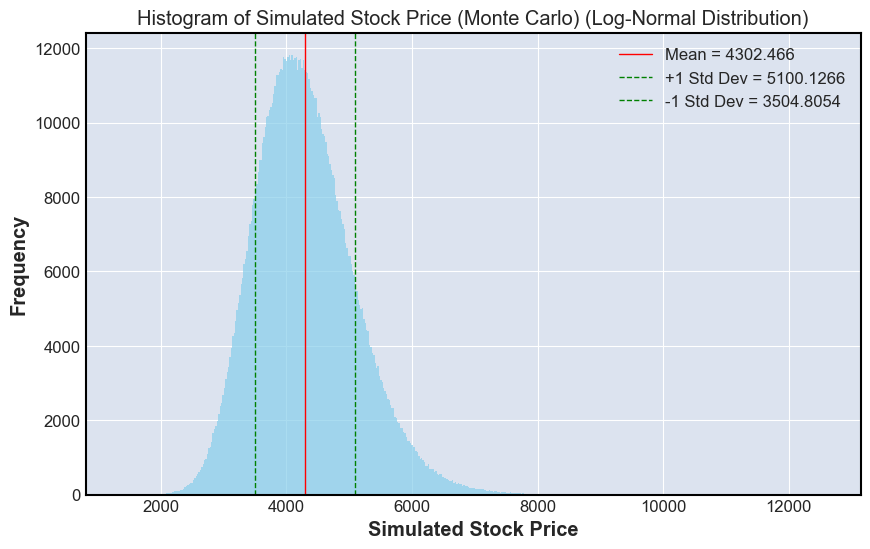

In [861]:
plt.figure(figsize=(10, 6))
plt.hist(St_monte_carlo, bins=500, color='skyblue', alpha=0.7)
St_monte_carlo_labels = {
    'Mean': ('Mean = ' + str(St_monte_carlo_mean)),
    'upper_sd': ('+1 Std Dev = ' + str(np.round(St_monte_carlo_mean + St_monte_carlo_std, 4))),
    'lower_sd': ('-1 Std Dev = ' + str(np.round(St_monte_carlo_mean - St_monte_carlo_std, 4)))
}
plt.axvline(St_monte_carlo_mean, color='red', linestyle='-', linewidth=1, label=St_monte_carlo_labels['Mean'])
plt.axvline(np.round(St_monte_carlo_mean + St_monte_carlo_std, 4), color='green', linestyle='--', linewidth=1, label=St_monte_carlo_labels['upper_sd'])
plt.axvline(np.round(St_monte_carlo_mean - St_monte_carlo_std, 4), color='green', linestyle='--', linewidth=1, label=St_monte_carlo_labels['lower_sd'])
plt.xlabel('Simulated Stock Price')
plt.ylabel('Frequency')
plt.title('Histogram of Simulated Stock Price (Monte Carlo) (Log-Normal Distribution)')
plt.legend()
plt.show()

### Simulating the Call Option Price using monte carlo

In [823]:
St = St_monte_carlo_mean
print(f"S0 = {S0}, St = {St}, K = {K}, r = {r}, T = {T}, sigma={s2.mean()}")
call_option_price = bsHelper.black_scholes(St, K, r, T, t, s2.mean())
print(call_option_price)

S0 = 4136.48, St = 4330.5137, K = 4015, r = 0.0456598, T = 11, sigma=0.18324296713094967
324.76352589241196


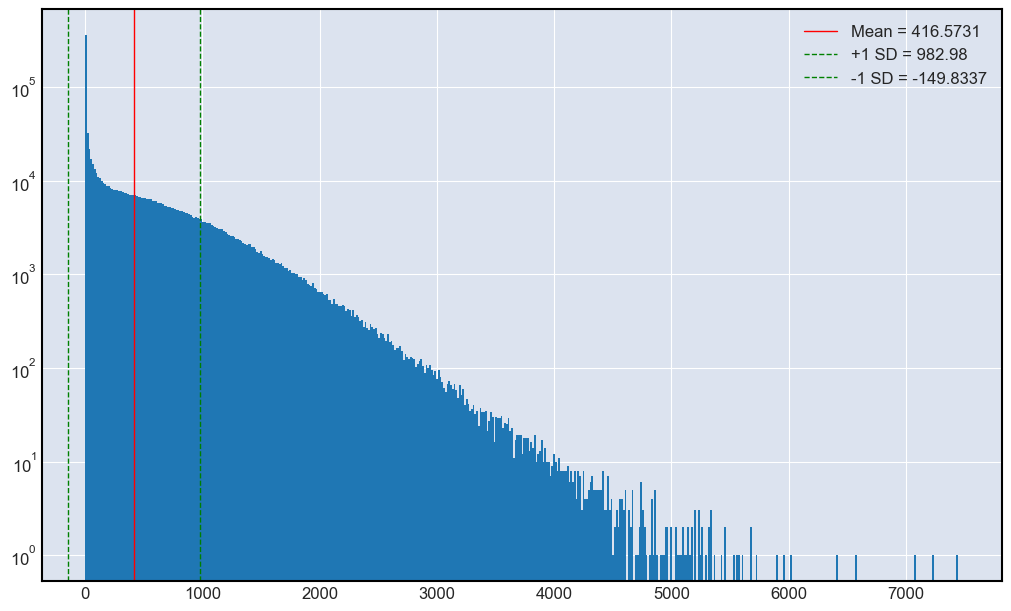

In [679]:
call_option_prices = bsHelper.black_scholes(St_monte_carlo, K, r, T, t, s2)
fig, ax1 = plt.subplots(1, 1, layout='constrained', figsize=(10, 6))

call_option_prices_mean = call_option_prices.mean()
call_option_prices_std = call_option_prices.std()


ax1.hist(call_option_prices, bins=500)
ax1.axvline(call_option_prices_mean, color='r', linewidth=1, label=f'Mean = {np.round(call_option_prices_mean, 4)}')
ax1.axvline(call_option_prices_mean + call_option_prices_std, linestyle='--', color='g', linewidth=1, label=f'+1 SD = {np.round(call_option_prices_mean + call_option_prices_std, 4)}')
ax1.axvline(call_option_prices_mean - call_option_prices_std, linestyle='--', color='g', linewidth=1, label=f'-1 SD = {np.round(call_option_prices_mean - call_option_prices_std, 4)}')
ax1.set_yscale('log')
ax1.legend()
plt.show()

In [803]:
K = spx_options_data.iloc[0].strike_price
r = sofr.loc[curdate_str].TSFR1M/100 # Converting to percentage
T = (pd.to_datetime(expiry_date) - curdate).days
t = 0

iv_monte_carlo = bsHelper.newton_rhapson(St_monte_carlo_mean, K, r, T, t, s2.mean(), call_option_prices_mean, max_iterations=10000)


sigma=0.6275146807407852, sigma_next=0.627514698902991, i=2971
found the value at the 2971th iteration
Implied Volatility: 0.627514698902991, Call Price: 416.57213714170985


Computing the implied volatility on a particular date

In [801]:
px_close = spx_price.loc[curdate].close
r = sofr.loc[curdate_str].TSFR1M/100 # Converting to percentage
opt = spx_options_data.iloc[0]
time_delta = (pd.to_datetime(opt.exdate) - curdate)
T = time_delta.days
t = 0
sigma = 1/100 # Converting to percentage
print(opt.mid_price)
print(px_close, K, r, T, t, sigma)
implied_volatility = bsHelper.newton_rhapson(px_close, K, r, T, t, sigma, call_price=opt.mid_price, max_iterations=100000)



119.65
4111.08 4065 0.0456598 11 0 0.01
sigma=0.26436950675067344, sigma_next=0.2643695109371937, i=32267
found the value at the 32267th iteration
Implied Volatility: 0.2643695109371937, Call Price: 119.64900263408526


In [731]:
implied_volatility = bsHelper.newton_rhapson(px_close, K, r, T, t, 0.11, call_price=c, tolerance=0.00001)

Implied Volatility: 0.10315841083581738, Call Price: 109.08612487064102


In [ ]:
St = spx_price.loc[prev].close

In [773]:
spx_options_data

,date,symbol,best_bid,best_offer,mid_price,strike_price,cp_flag,exdate,exercise_style
0,2023-02-06,SPX 230217C4015000,118.8,120.5,119.65,4015,C,2023-02-17,SPX
1,2023-02-06,SPX 230217C4020000,115.3,116.2,115.75,4020,C,2023-02-17,SPX
2,2023-02-06,SPX 230217C4025000,111.4,112.3,111.85,4025,C,2023-02-17,SPX
3,2023-02-06,SPX 230217C4030000,107.6,108.5,108.05,4030,C,2023-02-17,SPX
4,2023-02-06,SPX 230217C4035000,103.9,104.8,104.35,4035,C,2023-02-17,SPX
5,2023-02-06,SPX 230217C4040000,100.2,101.1,100.65,4040,C,2023-02-17,SPX
6,2023-02-06,SPX 230217C4045000,96.7,97.4,97.05,4045,C,2023-02-17,SPX
7,2023-02-06,SPX 230217C4050000,93.1,93.9,93.50,4050,C,2023-02-17,SPX
8,2023-02-06,SPX 230217C4055000,89.5,90.4,89.95,4055,C,2023-02-17,SPX
9,2023-02-06,SPX 230217C4060000,86.2,86.9,86.55,4060,C,2023-02-17,SPX


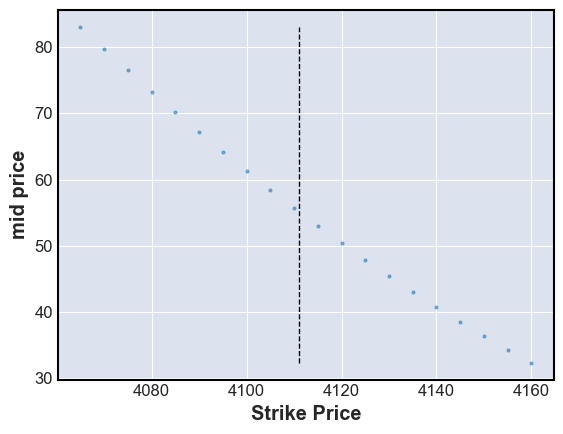

In [774]:
filt_data = spx_options_data[(spx_options_data['strike_price'] >= (px_close-50)) & (spx_options_data['strike_price'] <= (px_close+50))]

filt_data

plt.plot(filt_data['strike_price'], filt_data['mid_price'], 'o', markersize='2', alpha=0.5)
plt.xlabel('Strike Price')
plt.ylabel('mid price')
plt.vlines([px_close], [filt_data['mid_price'].min()], [filt_data['mid_price'].max()], colors=['black'], linestyles=['dashed'], linewidth=1)
plt.show()

In [775]:

opt = filt_data.iloc[0]
St = px_close
K = opt.strike_price
r = sofr.loc[curdate].TSFR1M/100 # Converting to percentage
time_delta = (pd.to_datetime(opt.exdate) - curdate)
T = time_delta.days
t = 0
sigma = 1/100 # Converting to percentage

bsHelper = BSHelper()

c = np.round(bsHelper.black_scholes(St, K, r, T, t, sigma), 2)
# c = bsHelper.black_scholes(St, K, r, T, t, sigma)
print(f"Calculated Price: {c}, Actual Price: {opt.mid_price}")

implied_volatility = bsHelper.newton_rhapson(St, K, r, T, t, sigma, call_price=opt.mid_price)


Calculated Price: 54.17, Actual Price: 83.1
cound not find root after 1000 iterations
Implied Volatility: 0.009824060049362825, Call Price: 54.17382812568576


In [10]:
smile = {
    'strike': [],
    'implied_volatility': []
}

for index, row in filt_data.iterrows():
    opt = row
    St = px_close
    K = opt.strike_price
    r = sofr.loc[curdate].TSFR1M/100 # Converting to percentage
    time_delta = (pd.to_datetime(opt.exdate) - curdate)
    T = time_delta.days
    t = 0
    sigma = 1/100 # Converting to percentage
    
    implied_volatility = bsHelper.newton_rhapson(St, K, r, T, t, sigma, call_price=opt.mid_price, suppressLogs=True)
    smile['strike'].append(K)
    smile['implied_volatility'].append(implied_volatility)

In [14]:
print(smile['implied_volatility'][0:10])

[0.009824060049362825, 0.009813617784571333, 0.009802858741405376, 0.0097920816958012, 0.009780391486686421, 0.00976838851935227, 0.009756094356545453, 0.009743327934907208, 0.00973083641875055, 0.009719211941132217]


/var/folders/9g/6smd7t3d5z5_cv63r3b4w2cr0000gn/T/ipykernel_29768/3742025497.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


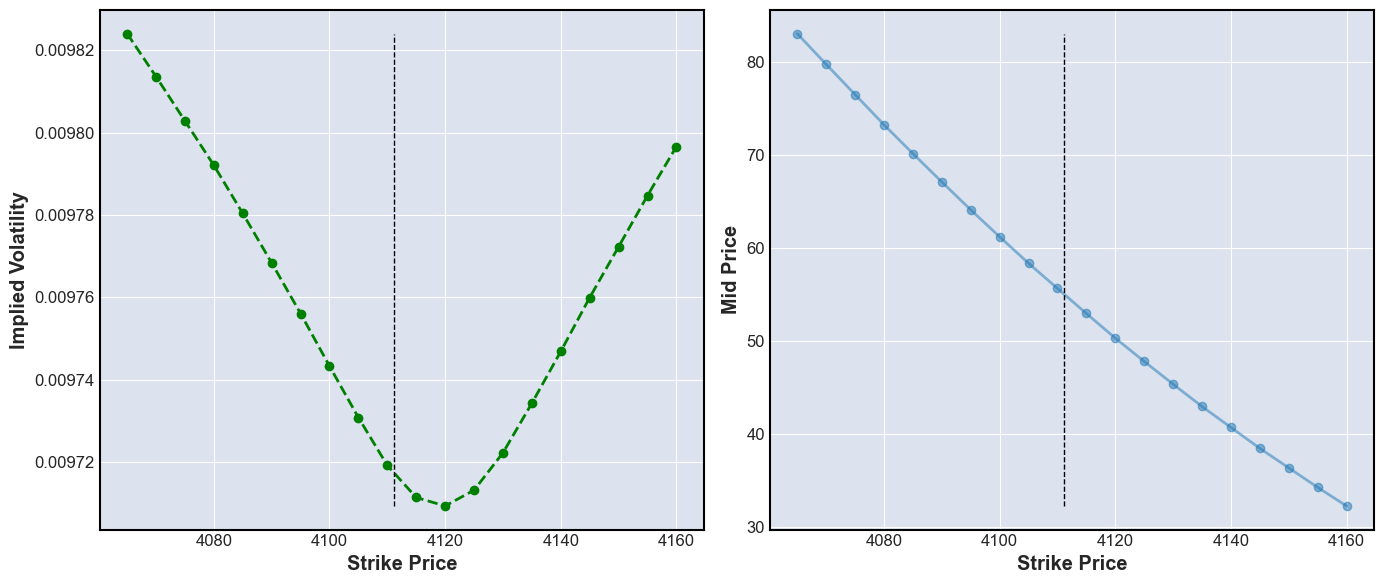

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6), sharex=False, width_ratios=[1,1])
ax1.plot(smile['strike'], smile['implied_volatility'], '--o', color='green')
ax1.set_xlabel('Strike Price')
ax1.set_ylabel('Implied Volatility')
ax1.vlines([px_close], [min(smile['implied_volatility'])], [max(smile['implied_volatility'])], colors=['black'], linestyles=['dashed'], linewidth=1)

ax2.plot(filt_data['strike_price'], filt_data['mid_price'], '-o', alpha=0.5)
ax2.set_xlabel('Strike Price')
ax2.set_ylabel('Mid Price')
ax2.vlines([px_close], [filt_data['mid_price'].min()], [filt_data['mid_price'].max()], colors=['black'], linestyles=['dashed'], linewidth=1)

fig.set_tight_layout(True)

fig.show()
